Explore different clustering algorithms for the networks

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Basics
import scipy.stats
import pickle
from collections import OrderedDict
import numpy as np
import pandas as pd
import seaborn as sns
#sns.set_context("paper")

# graphs
from igraph import *
import louvain

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# supporting function to plot a sorted adjacency matrix
def sort_adj_matrix(data, partition, colors=False):
    """
    Takes an igraph adj matrix and a partition solution (as in partition.membership from igraph) and returns a reordered block matrix according to the communities, in order of size.
    :param data: an adjacency matrix (as in G.get_adjacency(attribute='weight').data)
    :param partition: a list as in partition.membership
    :param colors: a boolean, default False. Use True if you plan to plot a coloured adj matrix.
    :return M: a numpy matrix which can be plotted with plt.matshow
    """
    dict_comm = OrderedDict()
    for n, (c,row) in enumerate(zip(partition,data)):
        if c not in dict_comm.keys():
            dict_comm[c] = list()
        dict_comm[c].append({"ix":n,"data":row})
    dict_comm = OrderedDict(sorted(dict_comm.items(),key=lambda x:x[0], reverse=False))
    list_of_lists = list()
    reverse_index = defaultdict(int)
    counter = 0
    for c in dict_comm.keys():
        for row in dict_comm[c]:
            reverse_index[row["ix"]] = counter
            counter += 1
    reverse_index = OrderedDict(sorted(reverse_index.items(),key=lambda x:x[1], reverse=False))
    reverse_index = [x for x in reverse_index.keys()]
    boundary_counter = 0
    prev_b = 0
    # this function also plots some basic stats for each cluster
    for c in dict_comm.keys():
        for row in dict_comm[c]:
            list_of_lists.append([row["data"][i] for i in reverse_index])
            boundary_counter += 1
        print("Boundary range for community %d: %d-%d"%(c,prev_b,boundary_counter))
        prev_b = boundary_counter
        # calculate volume of community vs total volume
        nodes_in = [x["ix"] for x in dict_comm[c]]
        weight_in = np.sum([np.sum([x["data"][i] for i in nodes_in]) for x in dict_comm[c]])
        total_weight = np.sum([np.sum(x["data"]) for x in dict_comm[c]])
        print("Number of nodes: %d"%len(nodes_in))
        print("Prop of volume in: %f"%np.divide(weight_in,total_weight))
    M = np.matrix(list_of_lists)
    if colors:
        # divide M by the mean value and rescale values to plot with colours
        M = np.divide(M,np.mean(M))
        M = np.multiply(M,255)
        M[np.where(M>255)] = 255
    return M

In [4]:
# choose the graph to load
G = Graph.Read_GraphML("dataset/graphs/bibc_1.graphml")
#G = Graph.Read_GraphML("dataset/graphs/directed.graphml")
#G = Graph.Read_GraphML("dataset/graphs/cocit_2.graphml")
summary(G)

IGRAPH U-W- 673 87419 -- 
+ attr: author (v), bid (v), core_age (v), core_type (v), field (v), id (v), in_lb (v), is_cited (v), is_citing (v), is_core (v), title (v), weight (e)


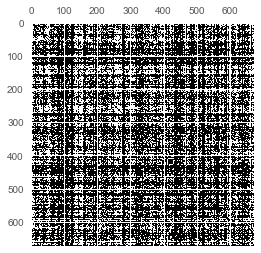

In [5]:
# plot the adj of the graph (BEWARE with large graphs)
im = G.get_adjacency()
plt.matshow(np.matrix(im.data), fignum=100, cmap=plt.cm.gray)

In [6]:
# components: is it connected?
comps = G.components()
print(len(comps.subgraphs()))
print(summary(comps.giant()))

3
IGRAPH U-W- 671 87419 -- 
+ attr: author (v), bid (v), core_age (v), core_type (v), field (v), id (v), in_lb (v), is_cited (v), is_citing (v), is_core (v), title (v), weight (e)
None


In [7]:
# just take the giant for analysis
G = comps.giant()

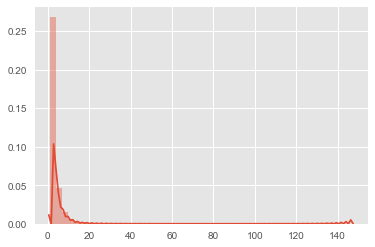

In [8]:
# distribution of edge weights
sns.distplot([e["weight"] for e in G.es])

Explore clustering solutions

Louvain from igraph

* VD Blondel, J-L Guillaume, R Lambiotte and E Lefebvre: Fast unfolding of community hierarchies in large networks, J Stat Mech P10008 (2008), http://arxiv.org/abs/0803.0476

In [15]:
partition = G.community_multilevel(weights='weight',return_levels=True)
for p in partition:
    print(len(set(p.membership)))

8
5


------
Modularity: 0.18622420701777104
Boundary range for community 0: 0-199
Number of nodes: 199
Prop of volume in: 0.607450
Boundary range for community 1: 199-201
Number of nodes: 2
Prop of volume in: 0.109756
Boundary range for community 2: 201-366
Number of nodes: 165
Prop of volume in: 0.394050
Boundary range for community 3: 366-399
Number of nodes: 33
Prop of volume in: 0.306214
Boundary range for community 4: 399-403
Number of nodes: 4
Prop of volume in: 0.207317
Boundary range for community 5: 403-444
Number of nodes: 41
Prop of volume in: 0.137280
Boundary range for community 6: 444-448
Number of nodes: 4
Prop of volume in: 0.295150
Boundary range for community 7: 448-671
Number of nodes: 223
Prop of volume in: 0.496459
------
Modularity: 0.18646363628677187
Boundary range for community 0: 0-199
Number of nodes: 199
Prop of volume in: 0.607450
Boundary range for community 1: 199-364
Number of nodes: 165
Prop of volume in: 0.394050
Boundary range for community 2: 364-407
Numb

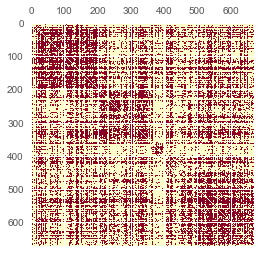

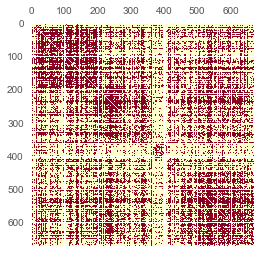

In [17]:
# explore 
for p in partition:
    print("------")
    # modularity
    print("Modularity: "+str(G.modularity(p.membership,weights="weight")))
    plt.matshow(sort_adj_matrix(G.get_adjacency(attribute='weight').data,p.membership,colors=True), cmap=plt.cm.YlOrRd)

Vincent Traag's Louvain

In [18]:
partition = louvain.find_partition(G, method='Modularity', weight='weight', resolution_parameter=1)
print(len(set(partition.membership)))

5


In [19]:
# modularity
print(partition.quality/(2*sum(G.es["weight"])))

0.18744345125123196


Boundary range for community 0: 0-262
Number of nodes: 262
Prop of volume in: 0.557337
Boundary range for community 1: 262-465
Number of nodes: 203
Prop of volume in: 0.610587
Boundary range for community 2: 465-585
Number of nodes: 120
Prop of volume in: 0.325827
Boundary range for community 3: 585-668
Number of nodes: 83
Prop of volume in: 0.202930
Boundary range for community 4: 668-671
Number of nodes: 3
Prop of volume in: 0.343137


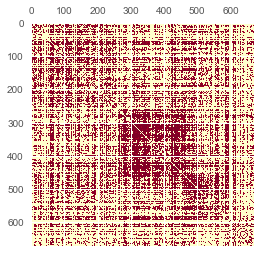

In [20]:
plt.matshow(sort_adj_matrix(G.get_adjacency(attribute='weight').data,partition.membership,colors=True), cmap=plt.cm.YlOrRd)

RBConfiguration

In [21]:
partition = louvain.find_partition(G, method='RBConfiguration', weight='weight', resolution_parameter=1)
print(len(set(partition.membership)))
# modularity
print(partition.quality/(2*sum(G.es["weight"])))

4
0.17682874634009912


Boundary range for community 0: 0-295
Number of nodes: 295
Prop of volume in: 0.605676
Boundary range for community 1: 295-547
Number of nodes: 252
Prop of volume in: 0.648518
Boundary range for community 2: 547-631
Number of nodes: 84
Prop of volume in: 0.203859
Boundary range for community 3: 631-671
Number of nodes: 40
Prop of volume in: 0.321488


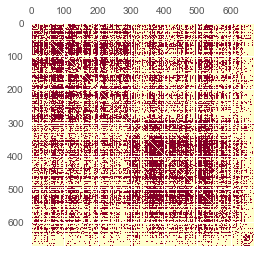

In [22]:
plt.matshow(sort_adj_matrix(G.get_adjacency(attribute='weight').data,partition.membership,colors=True), cmap=plt.cm.YlOrRd)

In [24]:
# explore the behaviour of RBConfiguration while changing the resolution parameter
n_communities = list()
for r in np.arange(0,3,0.1):
    partition = louvain.find_partition(G, method='RBConfiguration', weight='weight', resolution_parameter=r)
    n_communities.append(len(set(partition.membership)))

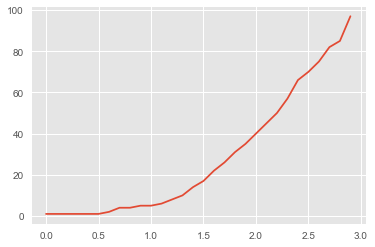

In [25]:
plt.plot(np.arange(0,3,0.1),n_communities)

Surprise

In [26]:
partition = louvain.find_partition(G, method='Surprise', weight='weight')
print(len(set(partition.membership)))
# modularity
print(partition.quality/(2*sum(G.es["weight"])))

153
0.22571232296900418


Boundary range for community 0: 0-293
Number of nodes: 293
Prop of volume in: 0.794079
Boundary range for community 1: 293-324
Number of nodes: 31
Prop of volume in: 0.182297
Boundary range for community 2: 324-343
Number of nodes: 19
Prop of volume in: 0.274061
Boundary range for community 3: 343-361
Number of nodes: 18
Prop of volume in: 0.111258
Boundary range for community 4: 361-373
Number of nodes: 12
Prop of volume in: 0.056279
Boundary range for community 5: 373-384
Number of nodes: 11
Prop of volume in: 0.075321
Boundary range for community 6: 384-394
Number of nodes: 10
Prop of volume in: 0.072778
Boundary range for community 7: 394-402
Number of nodes: 8
Prop of volume in: 0.056916
Boundary range for community 8: 402-410
Number of nodes: 8
Prop of volume in: 0.036455
Boundary range for community 9: 410-416
Number of nodes: 6
Prop of volume in: 0.126923
Boundary range for community 10: 416-422
Number of nodes: 6
Prop of volume in: 0.039265
Boundary range for community 11: 422

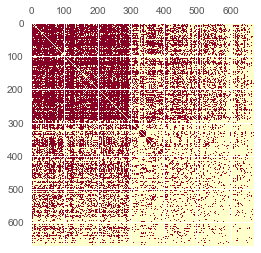

In [27]:
plt.matshow(sort_adj_matrix(G.get_adjacency(attribute='weight').data,partition.membership,colors=True), cmap=plt.cm.YlOrRd)

Significance

In [30]:
partition = louvain.find_partition(G, method='Significance')
print(len(set(partition.membership)))
# modularity
print(G.modularity(partition.membership))

90
0.006368506880163615


Boundary range for community 0: 0-307
Number of nodes: 307
Prop of volume in: 0.803772
Boundary range for community 1: 307-340
Number of nodes: 33
Prop of volume in: 0.116902
Boundary range for community 2: 340-363
Number of nodes: 23
Prop of volume in: 0.101535
Boundary range for community 3: 363-383
Number of nodes: 20
Prop of volume in: 0.068932
Boundary range for community 4: 383-400
Number of nodes: 17
Prop of volume in: 0.085358
Boundary range for community 5: 400-416
Number of nodes: 16
Prop of volume in: 0.056995
Boundary range for community 6: 416-430
Number of nodes: 14
Prop of volume in: 0.056329
Boundary range for community 7: 430-443
Number of nodes: 13
Prop of volume in: 0.075349
Boundary range for community 8: 443-455
Number of nodes: 12
Prop of volume in: 0.052279
Boundary range for community 9: 455-467
Number of nodes: 12
Prop of volume in: 0.047416
Boundary range for community 10: 467-474
Number of nodes: 7
Prop of volume in: 0.075552
Boundary range for community 11: 

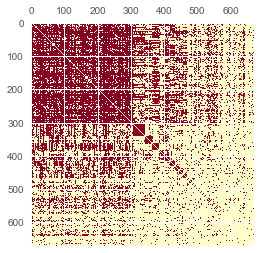

In [31]:
plt.matshow(sort_adj_matrix(G.get_adjacency(attribute='weight').data,partition.membership,colors=True), cmap=plt.cm.YlOrRd)

CMP

In [32]:
partition = louvain.find_partition(G, method='CPM', resolution_parameter=0.02)
print(len(set(partition.membership)))
# modularity
print(G.modularity(partition.membership))

11
9.125622311590067e-05


Boundary range for community 0: 0-658
Number of nodes: 658
Prop of volume in: 0.999838
Boundary range for community 1: 658-662
Number of nodes: 4
Prop of volume in: 0.313725
Boundary range for community 2: 662-663
Number of nodes: 1
Prop of volume in: 0.000000
Boundary range for community 3: 663-664
Number of nodes: 1
Prop of volume in: 0.000000
Boundary range for community 4: 664-665
Number of nodes: 1
Prop of volume in: 0.000000
Boundary range for community 5: 665-666
Number of nodes: 1
Prop of volume in: 0.000000
Boundary range for community 6: 666-667
Number of nodes: 1
Prop of volume in: 0.000000
Boundary range for community 7: 667-668
Number of nodes: 1
Prop of volume in: 0.000000
Boundary range for community 8: 668-669
Number of nodes: 1
Prop of volume in: 0.000000
Boundary range for community 9: 669-670
Number of nodes: 1
Prop of volume in: 0.000000
Boundary range for community 10: 670-671
Number of nodes: 1
Prop of volume in: 0.000000


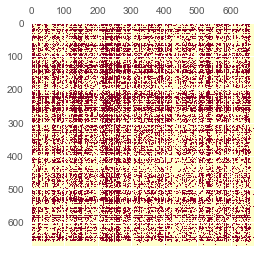

In [33]:
plt.matshow(sort_adj_matrix(G.get_adjacency(attribute='weight').data,partition.membership,colors=True), cmap=plt.cm.YlOrRd)

In [34]:
# explore the behaviour of CMP while changing the resolution parameter
n_communities = list()
for r in np.logspace(-5,-1,10):
    partition = louvain.find_partition(G, method='CPM', resolution_parameter=r)
    n_communities.append(len(set(partition.membership)))

In [35]:
np.logspace(-5,-1,10)

array([  1.00000000e-05,   2.78255940e-05,   7.74263683e-05,
         2.15443469e-04,   5.99484250e-04,   1.66810054e-03,
         4.64158883e-03,   1.29154967e-02,   3.59381366e-02,
         1.00000000e-01])

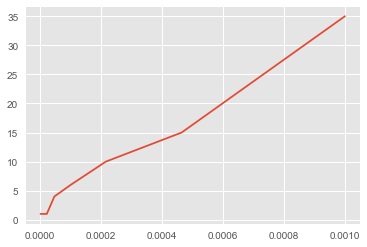

In [36]:
plt.plot(np.logspace(-6,-3,10),n_communities)

Infomap

In [37]:
partition = G.community_infomap(edge_weights='weight', trials=50)
print(len(set(partition.membership)))
# modularity
print(G.modularity(partition.membership,weights="weight"))

3
0.004344879234615294


Boundary range for community 0: 0-653
Number of nodes: 653
Prop of volume in: 0.996976
Boundary range for community 1: 653-666
Number of nodes: 13
Prop of volume in: 0.423442
Boundary range for community 2: 666-671
Number of nodes: 5
Prop of volume in: 0.305882


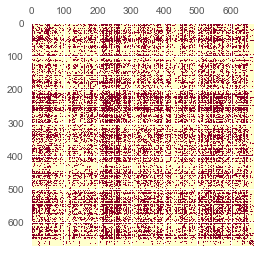

In [38]:
plt.matshow(sort_adj_matrix(G.get_adjacency(attribute='weight').data,partition.membership,colors=True), cmap=plt.cm.YlOrRd)

In [39]:
# Significance of partitions
# CF. Traag et al. 2013 Significant Scales in Community Structure

In [40]:
res_parts = louvain.bisect(G, method='RBConfiguration', resolution_range=[0,2], weight='weight')

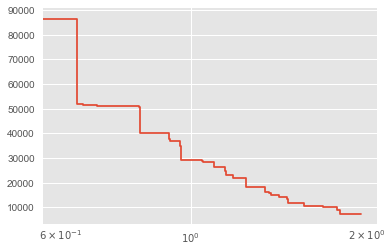

In [41]:
res_df = pd.DataFrame({
         'resolution': [x for x in res_parts.keys()],
         'bisect_value': [bisect.bisect_value for bisect in res_parts.values()]})
plt.step(res_df['resolution'], res_df['bisect_value'])
plt.xscale('log')

In [42]:
res_parts = louvain.bisect(G, method='CPM', resolution_range=[0,1], weight='weight')

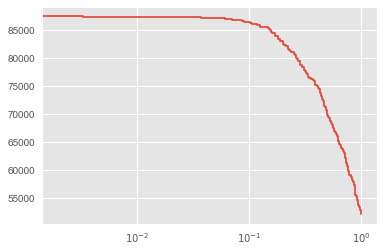

In [43]:
res_df = pd.DataFrame({
         'resolution': [x for x in res_parts.keys()],
         'bisect_value': [bisect.bisect_value for bisect in res_parts.values()]})
plt.step(res_df['resolution'], res_df['bisect_value'])
plt.xscale('log')